In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# CNN model

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from PIL import Image
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix,precision_score,roc_curve,auc,recall_score,precision_score

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.layers import AveragePooling2D,MaxPooling2D

In [ ]:
WORK_DIR = '/content/drive/MyDrive/Colab Notebooks/rose_leaf_detection/dataset'

CLASSES = [ 'Healthy_Leaf_Rose','Rose_Rust','Rose_sawfly_Rose_slug' ]

IMG=224

IMAGE_SIZE = [224, 224]
DIM = (IMG,IMG )

model_acc={}
model_val_acc={}

In [ ]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6320, shuffle=False)

Found 6320 images belonging to 3 classes.


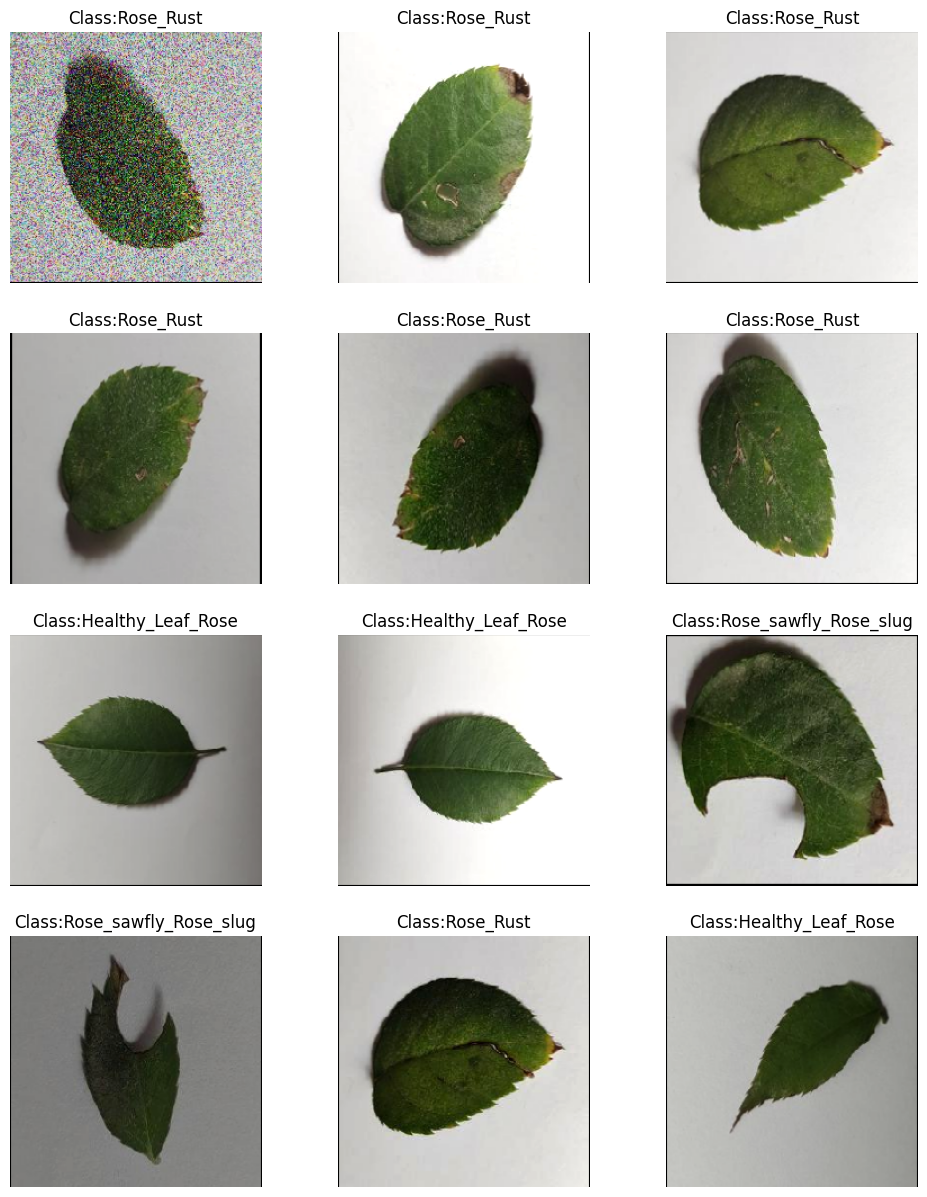

In [ ]:
from random import randint

# get image lables
labels =dict(zip([0,1,2], CLASSES))
# get a batch of images
train_data, train_labels = train_data_gen.next()

# display a grid of 9 images
plt.figure(figsize=(12, 15))
for i in range(12):
  ax = plt.subplot(4, 3, i + 1)
  idx = randint(0,6000)
  plt.imshow(train_data[idx])
  plt.axis("off")
  plt.title("Class:{}".format(labels[np.argmax(train_labels[idx])]))

In [ ]:
print(train_data.shape, train_labels.shape)

(6320, 224, 224, 3) (6320, 3)


In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)


In [ ]:
print(train_data.shape)

(5056, 224, 224, 3)


In [ ]:
# Create a CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the CNN model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
EPOCHS = 10
history1 = cnn_model.fit(train_data, train_labels, validation_data=(test_data, test_labels),batch_size=32, epochs=EPOCHS)

In [ ]:
acc=history1.history['accuracy']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history1.history['val_accuracy']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("no of epochs vs accuracy")
plt.legend()

In [ ]:
acc=history1.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history1.history['val_loss']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation loss")
plt.title("no of epochs vs loss")
plt.legend()

In [ ]:
Train_acc1=history1.history['accuracy'][-1]
Val_acc1=history1.history['val_accuracy'][-1]

model_acc["CNN"]=Train_acc1
model_val_acc["CNN"]=Val_acc1

print("Train accuracy",Train_acc1)
print("Validation accuracy",Val_acc1)

Train accuracy 0.9444647431373596
Validation accuracy 0.8852459192276001


In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs1 = cnn_model.predict(test_data, batch_size=32)

[INFO] evaluating network...
10/10 [==============================] - 0s 25ms/step


In [ ]:
# label with corresponding largest predicted probability
predIdxs1 = np.argmax(predIdxs1, axis=1)

In [ ]:
# show a nicely formatted classification report
print(classification_report(test_labels.argmax(axis=1), predIdxs1))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       138
           1       0.89      0.90      0.90       167

    accuracy                           0.89       305
   macro avg       0.88      0.88      0.88       305
weighted avg       0.89      0.89      0.89       305



In [ ]:
cf1=confusion_matrix(test_labels.argmax(axis=1), predIdxs1)
cf1

array([[120,  18],
       [ 17, 150]])

In [ ]:
import seaborn as sns
sns.heatmap(cf1, annot=True,fmt="1.0f")

# Mobile NetV2

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
baseModel.summary()

In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(32, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model_1 = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
#Defining other parameters for our CNN model
model_1.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
EPOCHS = 10
history2 = model_1.fit(train_data, train_labels, validation_data=(test_data, test_labels),batch_size=32, epochs=EPOCHS)

Epoch 1/20
86/86 [==============================] - 21s 147ms/step - loss: 0.6294 - acc: 0.6909 - val_loss: 0.5173 - val_acc: 0.7607
Epoch 2/20
86/86 [==============================] - 9s 108ms/step - loss: 0.5131 - acc: 0.7841 - val_loss: 0.4695 - val_acc: 0.8000
Epoch 3/20
86/86 [==============================] - 9s 108ms/step - loss: 0.4665 - acc: 0.7961 - val_loss: 0.4768 - val_acc: 0.7705
Epoch 4/20
86/86 [==============================] - 9s 108ms/step - loss: 0.4536 - acc: 0.8034 - val_loss: 0.4263 - val_acc: 0.8098
Epoch 5/20
86/86 [==============================] - 9s 109ms/step - loss: 0.4333 - acc: 0.8089 - val_loss: 0.4036 - val_acc: 0.8426
Epoch 6/20
86/86 [==============================] - 9s 109ms/step - loss: 0.4181 - acc: 0.8268 - val_loss: 0.3959 - val_acc: 0.8295
Epoch 7/20
86/86 [==============================] - 10s 112ms/step - loss: 0.4110 - acc: 0.8239 - val_loss: 0.3861 - val_acc: 0.8393
Epoch 8/20
86/86 [==============================] - 9s 110ms/step - loss: 

In [ ]:
acc=history2.history['accuracy']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history2.history['val_accuracy']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("no of epochs vs accuracy")
plt.legend()

In [ ]:
Train_acc2=history2.history['accuracy'][-1]
Val_acc2=history2.history['val_accuracy'][-1]

model_acc["MobileNetV2"]=Train_acc2
model_val_acc["MobileNetV2"]=Val_acc2
print("Train accuracy",Train_acc2)
print("Validation accuracy",Val_acc2)

In [ ]:
acc=history2.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history2.history['val_loss']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation loss")
plt.title("no of epochs vs loss")
plt.legend()

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs2 = model_1.predict(test_data, batch_size=32)

In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs2 = np.argmax(predIdxs2, axis=1)

In [ ]:
# show a nicely formatted classification report
print(classification_report(test_labels.argmax(axis=1), predIdxs2))

In [ ]:
cf2=confusion_matrix(test_labels.argmax(axis=1), predIdxs2)
cf2

In [ ]:
import seaborn as snsc
sns.heatmap(cf2, annot=True,fmt="1.0f")

# Resnet 50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import models, layers

In [ ]:
import tensorflow as tf
base_model = tf.keras.applications.ResNet50(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=(224,224,3),
                pooling=None,
            )
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
def resnet():

    model = Sequential()
    model.add(base_model)

    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3,activation='softmax'))

    return model

In [ ]:
model3 = resnet()

In [ ]:
#Defining other parameters for our CNN model
model3.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
EPOCHS = 10
history3 = model3.fit(train_data, train_labels, validation_data=(test_data, test_labels),batch_size=32, epochs=EPOCHS)

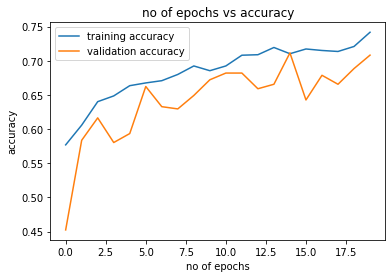

In [ ]:
acc=history3.history['accuracy']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history3.history['val_accuracy']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("no of epochs vs accuracy")
plt.legend()

In [ ]:
Train_acc3=history3.history['accuracy'][-1]
Val_acc3=history3.history['val_accuracy'][-1]

model_acc["ResNet50"]=Train_acc3
model_val_acc["ResNet50"]=Val_acc3

print("Train accuracy",Train_acc3)
print("Validation accuracy",Val_acc3)

In [ ]:
acc=history3.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history3.history['val_loss']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation loss")
plt.title("no of epochs vs loss")
plt.legend()

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs3 = model3.predict(test_data, batch_size=32)

[INFO] evaluating network...
10/10 [==============================] - 2s 95ms/step


In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs3 = np.argmax(predIdxs3, axis=1)

In [ ]:
# show a nicely formatted classification report
print(classification_report(test_labels.argmax(axis=1), predIdxs3))

              precision    recall  f1-score   support

           0       0.83      0.45      0.58       138
           1       0.67      0.92      0.78       167

    accuracy                           0.71       305
   macro avg       0.75      0.69      0.68       305
weighted avg       0.74      0.71      0.69       305



In [ ]:
cf3=confusion_matrix(test_labels.argmax(axis=1), predIdxs3)
cf3

In [ ]:
import seaborn as snsc
sns.heatmap(cf3, annot=True,fmt="1.0f")

# VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

In [ ]:
model4 = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
model4.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 sequential_15 (Sequential)  (None, 56, 56, 32)        14016     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 sequential_16 (Sequential)  (None, 14, 14, 64)        55

In [ ]:
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

#Adding custom Layers
x = model4.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation="softmax")(x)

# creating the final model
model_4 =  Model(inputs=model4.input, outputs=predictions)
model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model4.layers[:25]:
    layer.trainable = False

In [ ]:
#Defining other parameters for our CNN model
from tensorflow.keras import Sequential, Input
model_4.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
EPOCHS = 10
history4 = model_4.fit(train_data, train_labels, validation_data=(test_data, test_labels),batch_size=32, epochs=EPOCHS)

Epoch 1/20
86/86 [==============================] - 21s 202ms/step - loss: 0.9250 - acc: 0.6920 - val_loss: 0.5107 - val_acc: 0.7377
Epoch 2/20
86/86 [==============================] - 15s 177ms/step - loss: 0.4566 - acc: 0.7961 - val_loss: 0.5510 - val_acc: 0.7246
Epoch 3/20
86/86 [==============================] - 15s 177ms/step - loss: 0.4163 - acc: 0.8202 - val_loss: 0.4736 - val_acc: 0.7607
Epoch 4/20
86/86 [==============================] - 15s 177ms/step - loss: 0.3593 - acc: 0.8429 - val_loss: 0.3768 - val_acc: 0.8230
Epoch 5/20
86/86 [==============================] - 15s 177ms/step - loss: 0.3462 - acc: 0.8509 - val_loss: 0.4234 - val_acc: 0.7934
Epoch 6/20
86/86 [==============================] - 16s 182ms/step - loss: 0.3092 - acc: 0.8739 - val_loss: 0.3758 - val_acc: 0.8131
Epoch 7/20
86/86 [==============================] - 15s 179ms/step - loss: 0.3017 - acc: 0.8747 - val_loss: 0.3362 - val_acc: 0.8623
Epoch 8/20
86/86 [==============================] - 15s 178ms/step - 

In [ ]:
acc=history4.history['accuracy']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history4.history['val_accuracy']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("no of epochs vs accuracy")
plt.legend()

In [ ]:
acc=history4.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history4.history['val_loss']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation loss")
plt.title("no of epochs vs loss")
plt.legend()

In [ ]:
Train_acc4=history4.history['accuracy'][-1]
Val_acc4=history4.history['val_accuracy'][-1]

model_acc["VGG16"]=Train_acc4
model_val_acc["VGG16"]=Val_acc4

print("Train accuracy",Train_acc4)
print("Validation accuracy",Val_acc4)

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs4 = model_4.predict(test_data, batch_size=32)

In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs4 = np.argmax(predIdxs4, axis=1)

In [ ]:
# show a nicely formatted classification report
print(classification_report(test_labels.argmax(axis=1), predIdxs4))

In [ ]:
cf4=confusion_matrix(test_labels.argmax(axis=1), predIdxs4)
cf4

In [ ]:
import seaborn as sns
sns.heatmap(cf4, annot=True,fmt="1.0f")

# Model Evaluations

# Model training accuracy

In [ ]:
model_scores = pd.DataFrame(model_acc, index=['Score']).transpose()
model_scores = model_scores.sort_values('Score',ascending=False)

In [ ]:
model_scores

In [ ]:
model_scores = model_scores.reset_index().rename({"index":"Algorithms"}, axis = 1)

model_scores.style.bar()

In [ ]:
namess = list(model_acc.keys())
valuess = list(model_acc.values())
colors=["#00FFFF","#FFA500","#ADD8E6","#ED00D9","#ED1400"]
textprops = {"fontsize":22}

plt.figure(figsize=(7,4))
plt.bar(namess,valuess,color=colors)
plt.xlabel("Names")
plt.ylabel("Score")

#  Model Test accuracy

In [ ]:
model_scoress = pd.DataFrame(model_val_acc, index=['Score']).transpose()
model_scores_val = model_scoress.sort_values('Score',ascending=False)

In [ ]:
model_scores_val

In [ ]:
model_scores_val = model_scores_val.reset_index().rename({"index":"Algorithms"}, axis = 1)

model_scores_val.style.bar()

In [ ]:
names = list(model_val_acc.keys())
values = list(model_val_acc.values())
colors=["#00FFFF","#FFA500","#ADD8E6","#ED00D9","#ED1400"]
textprops = {"fontsize":22}

plt.figure(figsize=(7,4))
plt.bar(names,values,color=colors)
plt.xlabel("Names")
plt.ylabel("Score")


# predictions with CNN

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
imgg = cv2.imread("/content/drive/MyDrive/Colab Notebooks/dihan/dihan/Augmented Images/Monkeypox/M38_01_09.jpg") # monkey pox
imgg = cv2.resize(imgg, (260, 190))
cv2_imshow(imgg)

In [ ]:
# using the CNN model for predictions
# original image is Rose_Rust, now see what model predict.....
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/rose_leaf_detection/dataset/Rose_Rust/IMG_20230703_213438.jpg',target_size=(224,224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
result = cnn_model.predict(preprocessed_img).flatten()


In [ ]:
# generate the predictions

result1 = np.argmax(result)
if result1==0:
  print("img is : Healthy_Leaf_Rose")
elif result1==1:
  print("img is : Rose_Rust")
else:
  print("img is : Rose_sawfly_Rose_slug")


# predictions with MobileNetV2


In [ ]:
result2 = model_1.predict(preprocessed_img).flatten()

In [ ]:
# generate the predictions
result_2 = np.argmax(result2)
if result_2==0:
  print("img is : Healthy_Leaf_Rose")
elif result1==1:
  print("img is : Rose_Rust")
else:
  print("img is : Rose_sawfly_Rose_slug")

# predictions with Resnet50

In [ ]:
result3 = model3.predict(preprocessed_img).flatten()

In [ ]:
# generate the predictions
result_3 = np.argmax(result3)
if result_3==0:
  print("img is : Healthy_Leaf_Rose")
elif result1==1:
  print("img is : Rose_Rust")
else:
  print("img is : Rose_sawfly_Rose_slug")

# Predictions with VGG16

In [ ]:
result4 = model_4.predict(preprocessed_img).flatten()

In [ ]:
# generate the predictions
result_4 = np.argmax(result4)
if result_4==0:
  print("img is : Healthy_Leaf_Rose")
elif result1==1:
  print("img is : Rose_Rust")
else:
  print("img is : Rose_sawfly_Rose_slug")